In [321]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
data = load_wine()
df = pd.DataFrame({"Alcohol":data.data[:, 0], "Malic acid":data.data[:, 1],
                  "Ash":data.data[:, 2], "Alcalinity of ash":data.data[:, 3],
                  "Magnesium":data.data[:, 4], "Total phenols":data.data[:, 5],
                  "Flavanoids":data.data[:, 6], "Nonflavanoid phenols":data.data[:, 7],
                  "Proanthocyanins":data.data[:, 8], "Color intensity":data.data[:, 9],
                  "Hue":data.data[:, 10], "OD280/OD315 of diluted wines":data.data[:, 11],
                  "Proline":data.data[:, 12], "types":data.target})

In [322]:
import scipy.stats as st

def ttest(data1, data2):
    n = data1.shape[0]
    pearson = st.pearsonr(data1, data2)[0]
    if pearson == 1.:
        pearson = 0.99999
        
    T = pearson*np.sqrt(n-2)/np.sqrt(1-pearson**2)
    t_pval = 2 *(1 - st.distributions.t(n-2).cdf(abs(T)))
    return t_pval 

Так как выборочный коэффициент Пирсона неустойчив к выбросам, проверим данные на наличие таковых и удалим выбросы.

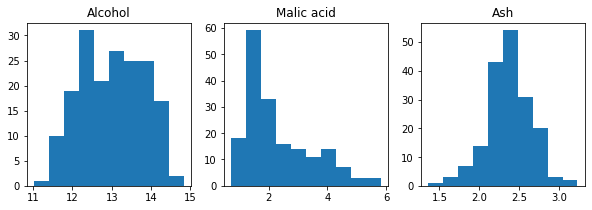

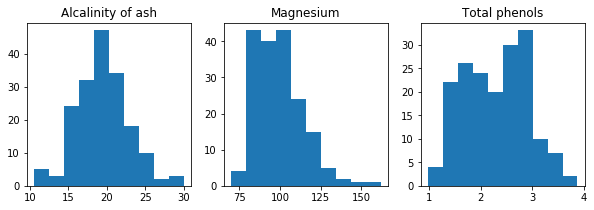

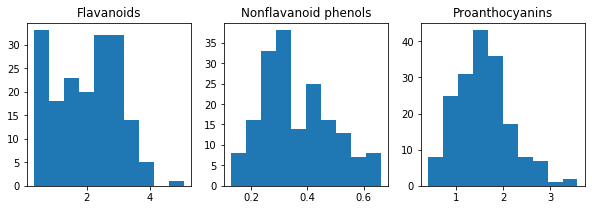

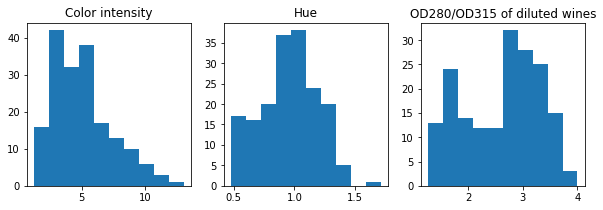

In [324]:
import matplotlib.pyplot as plt

def draw_hist(names_list):
    plt.figure(figsize=(10, 3))
    plt.subplot(131)
    plt.hist(df[names_list[0]])
    plt.title(names_list[0])
    
    plt.subplot(132)
    plt.hist(df[names_list[1]])
    plt.title(names_list[1])
    
    plt.subplot(133)
    plt.hist(df[names_list[2]])
    plt.title(names_list[2])
    
draw_hist(df.columns[:3])
draw_hist(df.columns[3:6])
draw_hist(df.columns[6:9])
draw_hist(df.columns[9:12])

In [325]:
df = df[df["Hue"] < 1.50].dropna()
df = df[df["Flavanoids"] < 4.50].dropna()

Найдем признаки, которые коррелируют с целевой переменной, а среди них оставим только линейно независимые признаки. Для этого будем исползовать t-тест Стьюдента и корреляцию Пирсона.

In [326]:
to_drop = set()
for name in df.columns:
    pvalue = ttest(df[name], df['types'])
    if pvalue >= 0.05:
        #нельзя утверждать, что корреляция этого признака и целевой переменной не равна 0  
        to_drop.add(name)
        print("{}: {}".format(name, pvalue))

Ash: 0.49017559361227936


In [327]:
df_new = df.drop(list(to_drop), axis=1)
to_drop = set()
for i in range(df_new.columns.shape[0]-1):
    for j in range(i+1, df_new.columns.shape[0]-1):
        name1, name2 = df_new.columns[i], df_new.columns[j]
        pvalue = ttest(df_new[name1], df[name2])
        if pvalue < 5e-2:
            to_drop.add(name2)
            print("{} & {}: {}".format(name1, name2, pvalue))

Alcohol & Alcalinity of ash: 0.0001047832900369361
Alcohol & Magnesium: 0.00016973668732434
Alcohol & Total phenols: 1.786458713004535e-05
Alcohol & Flavanoids: 0.00012822420551228397
Alcohol & Proanthocyanins: 0.038413144014395995
Alcohol & Color intensity: 2.886579864025407e-15
Alcohol & Proline: 0.0
Malic acid & Alcalinity of ash: 4.582560087551535e-05
Malic acid & Total phenols: 5.68614615725771e-06
Malic acid & Flavanoids: 7.917649424982187e-09
Malic acid & Nonflavanoid phenols: 4.5784034357065906e-05
Malic acid & Proanthocyanins: 0.003686205691177946
Malic acid & Color intensity: 0.0010136400630909037
Malic acid & Hue: 2.220446049250313e-16
Malic acid & OD280/OD315 of diluted wines: 4.98889000777325e-07
Malic acid & Proline: 0.007989511162055596
Alcalinity of ash & Total phenols: 1.4860752486356432e-06
Alcalinity of ash & Flavanoids: 7.168137416968534e-09
Alcalinity of ash & Nonflavanoid phenols: 1.406892351951683e-06
Alcalinity of ash & Proanthocyanins: 0.004634138537979116
Alca

In [328]:
df_new = df_new.drop(list(to_drop), axis=1)
df_new.columns

Index(['Alcohol', 'Malic acid', 'types'], dtype='object')

Таким образом, наиболее важными признаками для логистической регрессии являются 'Alcohol' и 'Malic acid' (или линейно зависящие от одного из них). Попробуем обучить модель на исходной выборке и на выборке, из которой выброшены все остальные признаки:

In [329]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


pipe = Pipeline([("scale", StandardScaler()), ("logreg", LogisticRegression())])
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
cross_val_score(pipe, data.data, data.target, cv=cv).mean()

0.9814814814814814

In [330]:
pipe = Pipeline([("scale", StandardScaler()), ("logreg", LogisticRegression())])
cross_val_score(pipe, df_new.drop('types', axis=1), df_new["types"], cv=cv).mean()

0.7672955974842767

Точность классификации упала, но не слишком сильно, и можно полагать, что два оставшихся признака дейсвительно являются наиболее существенными в данной задаче.